In [161]:
from ISLP import load_data
import pandas as pd
import numpy as np

## Getting Data

In [162]:
data = load_data('BrainCancer')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   sex        88 non-null     category
 1   diagnosis  87 non-null     category
 2   loc        88 non-null     category
 3   ki         88 non-null     int64   
 4   gtv        88 non-null     float64 
 5   stereo     88 non-null     category
 6   status     88 non-null     int64   
 7   time       88 non-null     float64 
dtypes: category(4), float64(2), int64(2)
memory usage: 3.8 KB


## Getting Dummies and Target

In [163]:
status = data['status'].astype(bool)
time_exit = data['time']
dummies = pd.get_dummies(data.drop(['status', 'time'], axis=1))

dummies

,ki,gtv,sex_Female,sex_Male,diagnosis_HG glioma,diagnosis_LG glioma,diagnosis_Meningioma,diagnosis_Other,loc_Infratentorial,loc_Supratentorial,stereo_SRS,stereo_SRT
0,90,6.11,True,False,False,False,True,False,True,False,True,False
1,90,19.35,False,True,True,False,False,False,False,True,False,True
2,70,7.95,True,False,False,False,True,False,True,False,True,False
3,80,7.61,True,False,False,True,False,False,False,True,False,True
4,90,5.06,False,True,True,False,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
83,80,0.16,False,True,True,False,False,False,False,True,False,True
84,80,19.81,False,True,True,False,False,False,False,True,False,True
85,90,2.50,False,True,False,False,True,False,False,True,False,True
86,90,2.02,False,True,False,False,True,False,False,True,True,False


# Kaplan-Meier Curve

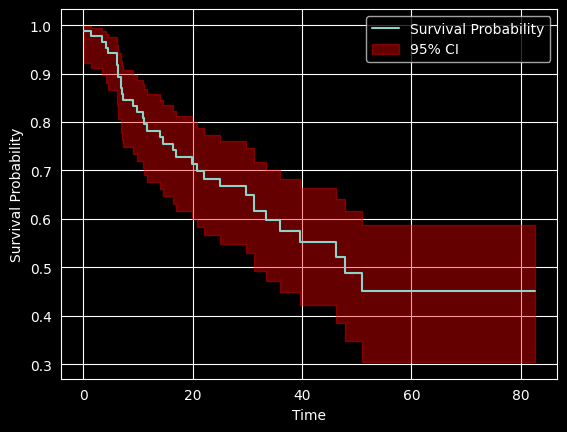

In [164]:
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt

time, prob_surv, conf_int = kaplan_meier_estimator(
    status, time_exit, conf_type='log-log',  conf_level=0.95
)

plt.step(time, prob_surv, where="post", label="Survival Probability")
plt.fill_between(time, conf_int[0], conf_int[1], step="post", alpha=0.4, color="red", label = "95% CI")
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

## Bootstrap Curve

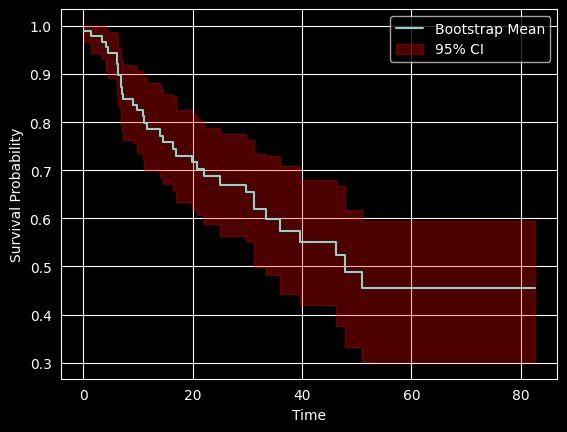

In [165]:
pairs = np.array(list(zip(time_exit, status)))
B = 200
n = len(pairs)


global_times = np.unique(time_exit)
global_times.sort()

all_probs = np.zeros((B, len(global_times)))

for i in range(B):
    idx = np.random.choice(n, size=n, replace=True)
    boot_data = pairs[idx]

    time_b, prob_b = kaplan_meier_estimator(
        boot_data[:, 1].astype(bool),
        boot_data[:, 0]
    )


    indices = np.searchsorted(time_b, global_times, side='right') - 1
    indices = np.clip(indices, 0, len(prob_b) - 1)
    all_probs[i, :] = prob_b[indices]

mean_surv = np.mean(all_probs, axis=0)
lower_ci = np.percentile(all_probs, 2.5, axis=0)
upper_ci = np.percentile(all_probs, 97.5, axis=0)

plt.step(global_times, mean_surv, where="post", label="Bootstrap Mean")
plt.fill_between(global_times, lower_ci, upper_ci, step="post", alpha=0.3, color="red", label="95% CI")
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

## Together

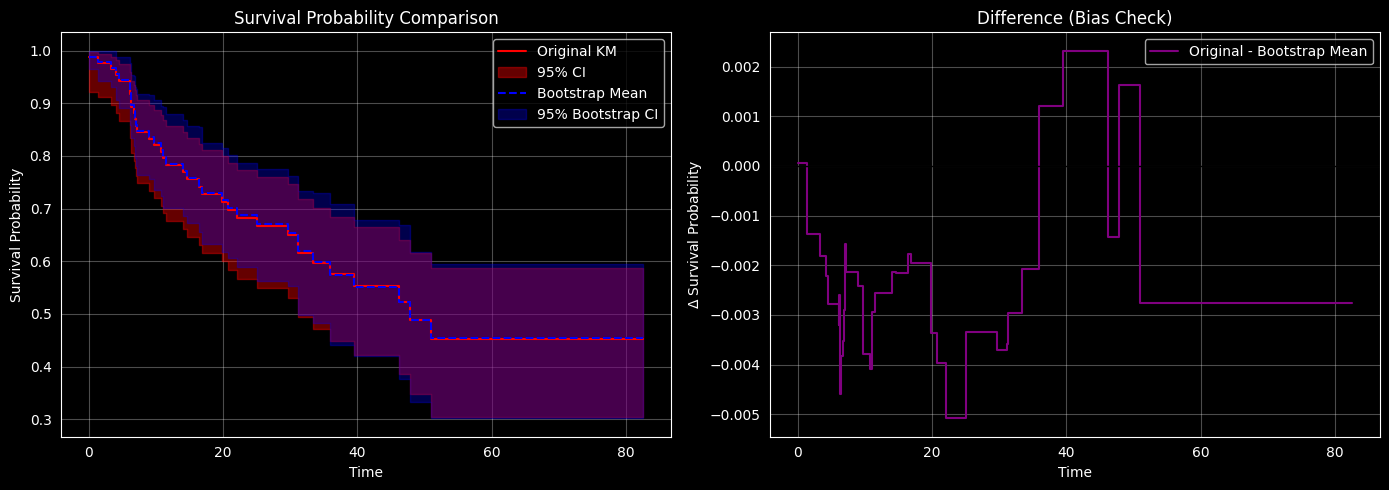

In [167]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))


# Original Curve
ax1.step(global_times, prob_surv_grid, where="post", label="Original KM", color="red", linewidth=1.5)
ax1.fill_between(global_times, conf_int[0], conf_int[1], step="post", alpha=0.4, color="red", label="95% CI")

# Bootstrap Curve
ax1.step(global_times, mean_surv, where="post", label="Bootstrap Mean", color="blue", linestyle="--")
ax1.fill_between(global_times, lower_ci, upper_ci, step="post", alpha=0.3, color="blue", label="95% Bootstrap CI")

ax1.set_title('Survival Probability Comparison')
ax1.set_xlabel('Time')
ax1.set_ylabel('Survival Probability')
ax1.legend()
ax1.grid(True, alpha=0.3)


diff = prob_surv_grid - mean_surv
ax2.step(global_times, diff, where="post", color="purple", label="Original - Bootstrap Mean")
ax2.axhline(0, color='black', lw=1, ls='-')

ax2.set_title('Difference (Bias Check)')
ax2.set_xlabel('Time')
ax2.set_ylabel('$\Delta$ Survival Probability')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()